<a href="https://colab.research.google.com/github/nmarcella/Xron/blob/main/Objective_training/NiClZnK_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the reproduction of results presented in: Neural network – based analysis of multimodal bond distributions using their EXAFS spectra
Submitted to PRL

Nicholas Marcella1* , Stephen Lam,2 Vyacheslav Bryantsev,3 Santanu Roy3 and Anatoly I. Frenkel4,5*
1 Department of Chemistry, University of Illinois, Urbana, Illinois 61801, United States
2 Department of Chemical Engineering, University of Massachusetts Lowell, Lowell, Massachusetts 01854, United States
3 Chemical Sciences Division, Oak Ridge National Laboratory, Oak Ridge, Tennessee 37830, United States
4 Department of Materials Science and Chemical Engineering, Stony Brook University, Stony Brook, New York 11794, United States
5 Chemistry Division, Brookhaven National Laboratory, Upton, New York 11973, United States

Contact: nmarcella@bnl.gov, nmarcella.sbu@gmail.com



# READ ME!

# (1) Run these cells

In [6]:
!git clone https://github.com/nmarcella/Xron.git

Cloning into 'Xron'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 321 (delta 1), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (321/321), 710.92 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (178/178), done.
Filtering content: 100% (26/26), 783.02 MiB | 80.48 MiB/s, done.


In [2]:
!pip install fastdist
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.3 MB/s eta 0:00:00


# (2) Utilities

In [3]:
import pickle
import numpy as np
from numpy import pi, sin, cos, exp, sqrt, log, log10, zeros, ones, arange, interp, where, linspace
from scipy.fftpack import fft, ifft
from scipy.special import i0 as bessel_i0
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import glob
from fastdist import fastdist
from sklearn.model_selection import train_test_split
import os
import sys
import shutil

def k2(data):
    k, m = data.transpose()
    return np.asarray([k,k*k*m]).transpose()


def read_lines(filename):

    with open(filename, "rt") as fobject:
                f = fobject.readlines()
                lines_str = []

                for line in f:
                    lines_str.append(line.replace("\n", "").replace("\t", " "))
    return lines_str

# FT related functions taked from larch (https://xraypy.github.io/xraylarch/)

sqrtpi=sqrt(pi)
FT_WINDOWS = ('Kaiser-Bessel', 'Hanning', 'Parzen', 'Welch', 'Gaussian', 'Sine')
FT_WINDOWS_SHORT = tuple([a[:3].lower() for a in FT_WINDOWS])
mass_e = 9.1e-31;
hbar = 6.626e-34/(2*np.pi);

def ftwindow(x, xmin=None, xmax=None, dx=1, dx2=None,
             window='hanning', **kws):
    """
    create a Fourier transform window array.
    Parameters:
    -------------
      x:        1-d array array to build window on.
      xmin:     starting x for FT Window
      xmax:     ending x for FT Window
      dx:       tapering parameter for FT Window
      dx2:      second tapering parameter for FT Window (=dx)
      window:   name of window type
    Returns:
    ----------
    1-d window array.
    Notes:
    -------
    Valid Window names:
        hanning              cosine-squared taper
        parzen               linear taper
        welch                quadratic taper
        gaussian             Gaussian (normal) function window
        sine                 sine function window
        kaiser               Kaiser-Bessel function-derived window
    """
    if window is None:
        window = FT_WINDOWS_SHORT[0]
    nam = window.strip().lower()[:3]
    if nam not in FT_WINDOWS_SHORT:
        raise RuntimeError("invalid window name %s" % window)

    dx1 = dx
    if dx2 is None:  dx2 = dx1
    if xmin is None: xmin = min(x)
    if xmax is None: xmax = max(x)

    xstep = (x[-1] - x[0]) / (len(x)-1)
    xeps  = 1.e-4 * xstep
    x1 = max(min(x), xmin - dx1/2.0)
    x2 = xmin + dx1/2.0  + xeps
    x3 = xmax - dx2/2.0  - xeps
    x4 = min(max(x), xmax + dx2/2.0)

    if nam == 'fha':
        if dx1 < 0: dx1 = 0
        if dx2 > 1: dx2 = 1
        x2 = x1 + xeps + dx1*(xmax-xmin)/2.0
        x3 = x4 - xeps - dx2*(xmax-xmin)/2.0
    elif nam == 'gau':
        dx1 = max(dx1, xeps)

    def asint(val): return int((val+xeps)/xstep)
    i1, i2, i3, i4 = asint(x1), asint(x2), asint(x3), asint(x4)
    i1, i2 = max(0, i1), max(0, i2)
    i3, i4 = min(len(x)-1, i3), min(len(x)-1, i4)
    if i2 == i1: i1 = max(0, i2-1)
    if i4 == i3: i3 = max(i2, i4-1)
    x1, x2, x3, x4 = x[i1], x[i2], x[i3], x[i4]
    if x1 == x2: x2 = x2+xeps
    if x3 == x4: x4 = x4+xeps
    # initial window
    fwin =  zeros(len(x))
    if i3 > i2:
        fwin[i2:i3] = ones(i3-i2)

    # now finish making window
    if nam in ('han', 'fha'):
        fwin[i1:i2+1] = sin((pi/2)*(x[i1:i2+1]-x1) / (x2-x1))**2
        fwin[i3:i4+1] = cos((pi/2)*(x[i3:i4+1]-x3) / (x4-x3))**2
    elif nam == 'par':
        fwin[i1:i2+1] =     (x[i1:i2+1]-x1) / (x2-x1)
        fwin[i3:i4+1] = 1 - (x[i3:i4+1]-x3) / (x4-x3)
    elif nam == 'wel':
        fwin[i1:i2+1] = 1 - ((x[i1:i2+1]-x2) / (x2-x1))**2
        fwin[i3:i4+1] = 1 - ((x[i3:i4+1]-x3) / (x4-x3))**2
    elif nam  in ('kai', 'bes'):
        cen  = (x4+x1)/2
        wid  = (x4-x1)/2
        arg  = 1 - (x-cen)**2 / (wid**2)
        arg[where(arg<0)] = 0
        if nam == 'bes': # 'bes' : ifeffit 1.0 implementation of kaiser-bessel
            fwin = bessel_i0(dx* sqrt(arg)) / bessel_i0(dx)
            fwin[where(x<=x1)] = 0
            fwin[where(x>=x4)] = 0
        else: # better version
            scale = max(1.e-10, bessel_i0(dx)-1)
            fwin = (bessel_i0(dx * sqrt(arg)) - 1) / scale
    elif nam == 'sin':
        fwin[i1:i4+1] = sin(pi*(x4-x[i1:i4+1]) / (x4-x1))
    elif nam == 'gau':
        cen  = (x4+x1)/2
        fwin =  exp(-(((x - cen)**2)/(2*dx1*dx1)))
    return fwin

def xftf_prep(k, chi, kmin=0, kmax=20, kweight=2, dk=1, dk2=None,
                window='kaiser', nfft=2048, kstep=0.05):
    """
    calculate weighted chi(k) on uniform grid of len=nfft, and the
    ft window.
    Returns weighted chi, window function which can easily be multiplied
    and used in xftf_fast.
    """
    if dk2 is None: dk2 = dk
    npts = int(1.01 + max(k)/kstep)
    k_max = max(max(k), kmax+dk2)
    k_   = kstep * np.arange(int(1.01+k_max/kstep), dtype='float64')
    chi_ = interp(k_, k, chi)
    win  = ftwindow(k_, xmin=kmin, xmax=kmax, dx=dk, dx2=dk2, window=window)
    return ((chi_[:npts] *k_[:npts]**kweight), win[:npts])

def xftf_fast(chi, nfft=2048, kstep=0.05, **kws):
    cchi = zeros(nfft, dtype='complex128')
    cchi[0:len(chi)] = chi
    return (kstep / sqrtpi) * fft(cchi)[:int(nfft/2)]

def xftr_fast(chir, nfft=2048, kstep=0.05, **kws):
    """
    calculate reverse XAFS Fourier transform, from chi(R) to
    chi(q), using common XAFS conventions.  This version demands
    chir be the complex chi(R) as created from xftf().
    It returns the complex array of chi(q) without putting any
    values into an output group.
    Parameters:
    -------------
      chir:     1-d array of chi(R) to be transformed
      nfft:     value to use for N_fft (2048).
      kstep:    value to use for delta_k (0.05).
    Returns:
    ----------
      complex 1-d array for chi(q).
    This is useful for repeated FTs, as inside loops.
    """
    cchi = zeros(nfft, dtype='complex128')
    cchi[0:len(chir)] = chir
    return  (4*sqrtpi/kstep) * ifft(cchi)[:int(nfft/2)]


kspace = np.arange(2,12.05,.05)
time_space = np.arange(0,np.pi,.01)
rmeshPrime = np.arange(0,6,.025)
def chi_r(r):
    return np.asarray(list(map(lambda k: (1/r**2)*np.sin(2*k*r), kspace)))

def xftr(r, chir=None, rmin=0, rmax=20, with_phase=False,
            dr=1, dr2=None, rw=0, window='kaiser', qmax_out=None,
            nfft=2048, kstep=0.05, **kws):
    """
    reverse XAFS Fourier transform, from chi(R) to chi(q).
    calculate reverse XAFS Fourier transform
    This assumes that chir_re and (optional chir_im are
    on a uniform r-grid given by r.
    Parameters:
    ------------
      r:        1-d array of distance, or group.
      chir:     1-d array of chi(R)
      group:    output Group
      qmax_out: highest *k* for output data (30 Ang^-1)
      rweight:  exponent for weighting spectra by r^rweight (0)
      rmin:     starting *R* for FT Window
      rmax:     ending *R* for FT Window
      dr:       tapering parameter for FT Window
      dr2:      second tapering parameter for FT Window
      window:   name of window type
      nfft:     value to use for N_fft (2048).
      kstep:    value to use for delta_k (0.05).
      with_phase: output the phase as well as magnitude, real, imag  [False]
    Returns:
    ---------
      None -- outputs are written to supplied group.
    Notes:
    -------
    Arrays written to output group:
        rwin               window Omega(R) (length of input chi(R)).
        q                  uniform array of k, out to qmax_out.
        chiq               complex array of chi(k).
        chiq_mag           magnitude of chi(k).
        chiq_re            real part of chi(k).
        chiq_im            imaginary part of chi(k).
        chiq_pha           phase of chi(k) if with_phase=True
                           (a noticable performance hit)
    Supports First Argument Group convention (with group member names 'r' and 'chir')
    """
    if 'rweight' in kws:
        rw = kws['rweight']

    r = r
    chir = chir

    rstep = r[1] - r[0]
    kstep = pi/(rstep*nfft)
    scale = 1.0

    cchir = zeros(nfft, dtype='complex128')
    r_    = rstep * arange(nfft, dtype='float64')

    cchir[0:len(chir)] = chir
    if chir.dtype == np.dtype('complex128'):
        scale = 0.5

    win = ftwindow(r_, xmin=rmin, xmax=rmax, dx=dr, dx2=dr2, window=window)
    out = scale * xftr_fast( cchir*win * r_**rw, kstep=kstep, nfft=nfft)
    if qmax_out is None: qmax_out = 30.0
    q = linspace(0, qmax_out, int(1.05 + qmax_out/kstep))
    nkpts = len(q)

    group = {}
    group['q'] = q
    mag = sqrt(out.real**2 + out.imag**2)
    group['rwin'] =  win[:len(chir)]
    group['chiq']     =  out[:nkpts]
    group['chiq_mag'] =  mag[:nkpts]
    group['chiq_re']  =  out.real[:nkpts]
    group['chiq_im']  =  out.imag[:nkpts]
    if with_phase:
        group['chiq_pha'] =  complex_phase(out[:nkpts])
    return group

def interpol(exafs):
    global kspace
    x, y = exafs.transpose()
    f1=interp1d(x, y, kind='cubic')
    test_real=f1(kspace)
    return test_real

def intpol(data, energymesh):
    """
    data format is [[energies1, mus1]...[energy_n, mus_n]]
    """
    return np.interp(energymesh, xp=data[0:,0], fp=data[0:,1])

def read_exafs_dat(file_path):
    return np.asarray([[float(s) for s in l.split()] for l in [l for l in read_lines(file_path) if l.split()[0] != '#']])[:,[2,5]]

class ModelRunner2:

    def __init__(self, model_dict, x_test_ai, y_test_ai, rmeshPrime):
        self.model_dict = model_dict
        self.x_test_ai = x_test_ai
        self.y_test_ai = y_test_ai
        self.rmesh = rmesh

    def run(self, fig_size=(12,5), dpi=300):
        fig, axs = plt.subplots(2,8, figsize=fig_size, dpi=dpi)

        for i in range(8):
            test_index = i

            bins = self.rmesh[20:60]

            # Make predictions with all models in the dictionary
            predictions_list = []
            for model_name, model in self.model_dict.items():
                predictions = model.predict(np.array([self.x_test_ai[test_index]]))[0]
                predictions_list.append(predictions)

            # Calculate the mean and standard deviation of the predictions
            predictions_array = np.stack(predictions_list, axis=0)
            mean_predictions = np.mean(predictions_array, axis=0)
            std_predictions = np.std(predictions_array, axis=0)

            axs[0,i].plot(bins, mean_predictions[:40], color="green", alpha=0.9, label="ONNE")
            axs[0,i].fill_between(bins, mean_predictions[:40] - std_predictions[:40], mean_predictions[:40] + std_predictions[:40], color="green", alpha=0.3)

            counts = self.y_test_ai[test_index]
            axs[0,i].plot(bins, counts[:40], color="yellow", alpha=0.5, label="AIMD")

            axs[0,i].set_xlabel("r (Å)", fontsize=6)
            axs[0,i].set_ylabel("g(r)", fontsize=6)
            axs[0,i].xaxis.set_tick_params(labelsize=6)
            axs[0,i].yaxis.set_tick_params(labelsize=6)
            axs[0,i].legend(fontsize=6)
            axs[0,i].set_ylim(0,15)

            bins = self.rmesh[40:100]

            axs[1,i].plot(bins, mean_predictions[40:], color="green", alpha=0.9, label="ONNE")
            axs[1,i].fill_between(bins, mean_predictions[40:] - std_predictions[40:], mean_predictions[40:] + std_predictions[40:], color="green", alpha=0.3)

            counts = self.y_test_ai[test_index]
            axs[1,i].plot(bins, counts[40:], color="yellow", alpha=0.5, label="AIMD")

            axs[1,i].set_xlabel("r (Å)", fontsize=4)
            axs[1,i].set_ylabel("g(r)", fontsize=4)
            axs[1,i].xaxis.set_tick_params(labelsize=6)
            axs[1,i].yaxis.set_tick_params(labelsize=6)
            axs[1,i].set_ylim(0,8)

            axs[1,i].legend(fontsize=6)

        fig.tight_layout()

    def calculate_mean_std_mse(self):
        mse_list = []

        for test_index in range(len(self.y_test_ai)):
            mse_per_model = []

            for model_name, model in self.model_dict.items():
                prediction = model.predict(np.array([self.x_test_ai[test_index]]))[0]
                mse = mean_squared_error(self.y_test_ai[test_index], prediction)
                mse_per_model.append(mse)

            mse_list.append(mse_per_model)

        mse_array = np.array(mse_list)
        mean_mse = np.mean(mse_array, axis=1)
        std_mse = np.std(mse_array, axis=1)

        return mean_mse, std_mse


    def plot_mean_std_predictions(self, all_ai_exafs, ai_cl, ai_zn):
        fig, axs = plt.subplots(1,1, figsize=(2.5,3), dpi=300)

        # Make predictions with all models in the dictionary
        predictions_list = []
        for model_name, model in self.model_dict.items():
            predictions = model.predict(np.array([all_ai_exafs.reshape(201,1)]))[0]
            predictions_list.append(predictions)

        # Calculate the mean and standard deviation of the predictions
        predictions_array = np.stack(predictions_list, axis=0)
        mean_predictions = np.mean(predictions_array, axis=0)
        std_predictions = np.std(predictions_array, axis=0)


        bins = rmesh[20:60]

        axs.plot(bins, mean_predictions[:40], color="red", alpha=0.9, label="Ni-Cl ONNE")
        axs.fill_between(bins, mean_predictions[:40] - std_predictions[:40], mean_predictions[:40] + std_predictions[:40], color="green", alpha=0.3)


        axs.set_xlabel("r (Å)", fontsize=6)
        axs.set_ylabel("g(r)", fontsize=6)
        axs.xaxis.set_tick_params(labelsize=6)
        axs.yaxis.set_tick_params(labelsize=6)

        axs.set_ylim(0,15)

        bins = rmesh[40:100]

        axs.plot(bins, mean_predictions[40:], color="blue", alpha=0.9, label="Ni-Zn ONNE")
        axs.fill_between(bins, mean_predictions[40:] - std_predictions[40:], mean_predictions[40:] + std_predictions[40:], color="green", alpha=0.3)


        axs.set_xlabel("r (Å)", fontsize=9)
        axs.set_ylabel("g(r)", fontsize=9)
        axs.xaxis.set_tick_params(labelsize=6)
        axs.yaxis.set_tick_params(labelsize=6)
        axs.set_ylim(0,12.5)

        axs.plot(rmesh, ai_cl, color="red", alpha=0.5, label="Ni-Cl AIMD", linestyle="--")
        axs.plot(rmesh, ai_zn, color="blue", alpha=0.5, label="Ni-Zn AIMD", linestyle="--")
        axs.legend(fontsize=6)
        axs.set_xlim(1,5)

        fig.tight_layout()

# Make structures (one example)

## (3) Functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from numpy import sqrt, trapz

def write_xyz_file(filename, coordinate_array):
    with open(filename, 'w') as file:
        file.write(str(len(coordinate_array)) + "\n")
        file.write("Ni atoms\n")
        for coordinates in coordinate_array:
            file.write(f"Ni {coordinates[0]} {coordinates[1]} {coordinates[2]}\n")

def write_xyz_file_multiatom(filename, coordinate_array, atom_ids):
    with open(filename, 'w') as file:
        file.write(str(len(coordinate_array)) + "\n")
        file.write("Ni atoms\n")
        for atom_i,coordinates in enumerate(coordinate_array):
            file.write(f"{atom_ids[atom_i]} {coordinates[0]} {coordinates[1]} {coordinates[2]}\n")

def normal_distro_S1(mean, std):
    global S1
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S1 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S2(mean, std):
    global S2
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S2 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S3(mean, std):
    global S3
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S3 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S4(mean, std):
    global S4
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S4 = stats.norm(loc=mu, scale=sigma)

def integrate_mono(rdf ,rmesh, rrange):
    x,y = np.asarray([l for l in np.asarray([rmesh, rdf]).transpose() if rrange[0]<l[0]<rrange[1]]).transpose()
    return trapz(y,x)

def make_rdf_feff(distances, rmesh):
    digitized =np.digitize(distances
        , rmesh)
    unique, counts = np.unique(digitized, return_counts=True)
    counter = [0]*len(rmesh)
    for i in range(len(unique)):
        counter[unique[i]-1] = counts[i]/(rmesh[1]-rmesh[0])
    return np.asarray(counter)

def from_xyz(xyz, axis=-1):
    x, y, z = np.moveaxis(xyz, axis, 0)

    lea = np.empty_like(xyz)

    pre_selector = ((slice(None),) * lea.ndim)[:axis]

    xy_sq = x ** 2 + y ** 2
    lea[(*pre_selector, 0)] = np.sqrt(xy_sq + z ** 2)
    lea[(*pre_selector, 1)] = np.arctan2(np.sqrt(xy_sq), z)
    lea[(*pre_selector, 2)] = np.arctan2(y, x)

    return lea


def to_xyz(lea, axis=-1):
    l, e, a = np.moveaxis(lea, axis, 0)

    xyz = np.empty_like(lea)

    pre_selector = ((slice(None),) * xyz.ndim)[:axis]

    xyz[(*pre_selector, 0)] = l * np.sin(e) * np.cos(a)
    xyz[(*pre_selector, 1)] = l * np.sin(e) * np.sin(a)
    xyz[(*pre_selector, 2)] = l * np.cos(e)

    return xyz

def fibonacci_sphere(samples=1):

    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y*y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points.append([x, y, z])

    return points

def fibonacci_sphere_with_rescaling(target_rho_values, samples=1):
    # Generate points on a unit sphere using the Fibonacci Sphere algorithm
    points = fibonacci_sphere(samples)

    # Rescale the points to match the target rho values
    rescaled_points = []
    for i in range(len(target_rho_values)):
        # Retrieve the original point coordinates
        x, y, z = points[i]

        # Compute the original rho value
        original_rho = np.sqrt(x**2 + y**2 + z**2)

        # Compute the rescaling factor
        rescaling_factor = target_rho_values[i] / original_rho

        # Rescale the coordinates by multiplying with the rescaling factor
        rescaled_x = x * rescaling_factor
        rescaled_y = y * rescaling_factor
        rescaled_z = z * rescaling_factor

        # Append the rescaled point to the list
        rescaled_points.append([rescaled_x, rescaled_y, rescaled_z])

    return from_xyz(rescaled_points)


### GA

import logging
import random
from deap import creator, base, tools, algorithms
import numpy as np

#logging.basicConfig(filename='A:/Objective_training/Bulk/app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)


def d_sphere(rtp1, rtp2):
    r1, th1, ph1 = rtp1.T
    r2, th2, ph2 = rtp2.T
    return np.sqrt(r1**2+r2**2-2*r1*r2*np.cos((th1-th2))-2*r1*r2*np.sin(th1)*np.sin(th2)*(np.cos((ph1-ph2))-1))


def sph_dis_matrix(list_of_points):
    n_points = len(list_of_points)
    list_of_points = np.array(list_of_points)

    # The newaxis index operator inserts a new axis into list_of_points, making it a column vector,
    # and with broadcasting feature of numpy, it computes the d_sphere over each pair.
    dm = d_sphere(list_of_points[np.newaxis, :, :], list_of_points[:, np.newaxis, :])

    return dm

def find_min(list_of_points):
    tri = sph_dis_matrix(list_of_points)

    # numpy.triu returns the upper triangle of an array and "k=1" excludes the main diagonal.
    # Since the matrix is symmetric and the diagonal is zero, we just need to consider the upper triangle of the matrix.
    tri_upper = np.triu(tri, k=1)

    # We find the minimum in the upper triangle. Here we consider only the non-zero values.
    min_val = tri_upper[tri_upper > 0].min()

    return min_val


def optimize_structure(a_structure):

    logging.info('Starting optimization of a structure')

    def reassemble_points(rhos, thetas_phis):
        num_points = len(rhos)
        points = np.zeros((num_points, 3))
        thetas = thetas_phis[:num_points]
        phis = thetas_phis[num_points:]

        for i in range(num_points):
            points[i] = [rhos[i], thetas[i], phis[i]]

        return points

    def mutate_individual(individual, low, up, indpb, sigma=0.1):
        num_points = len(individual)
        for i in range(num_points):
            if random.random() < indpb:
                individual[i] += random.gauss(0, sigma)
                individual[i] = max(low[i], min(up[i], individual[i]))  # Apply bounds
        return individual,

    # Define the fitness and individual classes
    if not hasattr(creator, 'FitnessMax'):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, 'Individual'):
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Define the number of points
    num_points = len(a_structure)

    # Define the ranges for theta and phi
    theta_min, theta_max = -.02, .02
    phi_min, phi_max = -.02, .02

    # Define the bounds for theta and phi
    bounds = [(theta_min, theta_max)] * num_points + [(phi_min, phi_max)] * num_points

    # Attribute generator: randomly initialize theta and phi for each point
    toolbox.register("attr_angles", random.uniform, phi_min, phi_max)
    toolbox.register("attr_angles_theta", random.uniform, theta_min, theta_max)

    # Structure initializer: create an individual by randomly initializing the angles
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_angles_theta, toolbox.attr_angles), n=num_points)

    # Population initializer
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluate function: calculate the fitness as the negative of the minimum distance
    def evaluate(individual):
        thetas_i = individual[:num_points]
        phis_i = individual[num_points:]
        thetas_i = np.array(thetas_i)
        phis_i = np.array(phis_i)
        thetas = thetas_f + thetas_i
        phis = phis_f + phis_i
        points = reassemble_points(rhos, np.concatenate((thetas, phis)))
        return find_min(points),

    toolbox.register("evaluate", evaluate)

    # Genetic operators
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_individual, low=[phi_min] * num_points + [theta_min] * num_points,
                    up=[phi_max] * num_points + [theta_max] * num_points, indpb=0.2)

    # Initialize structure
    rhos = a_structure[:,0]
    thetas_f = a_structure[:,1]
    phis_f = a_structure[:,2]

    saved = reassemble_points(rhos, np.concatenate((thetas_f, phis_f)))

    logging.info('saved created')

    # Define the population size and number of generations
    population_size = 100
    num_generations = 10

    num_iterations = 300

    for iteration in range(num_iterations):
        logging.info('Starting iteration %d' % iteration)
        rhos = saved[:,0]
        thetas_f = saved[:,1]
        phis_f = saved[:,2]

        # Create the initial population
        population = toolbox.population(n=population_size)

        # Evaluate the initial population
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Define the hall of fame object
        hof = tools.HallOfFame(1)
        #logging.info('hof created')
        # Perform the genetic algorithm
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        population, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.5, ngen=num_generations,
                                            stats=stats, halloffame=hof, verbose=False)

        # Retrieve the best individual
        best_individual = hof[0]
        #logging.info('best individual retrieved')

        thetas_i = best_individual[:num_points]
        phis_i = best_individual[num_points:]
        thetas_i = np.array(thetas_i)
        phis_i = np.array(phis_i)
        thetas = thetas_f + thetas_i
        phis = phis_f + phis_i
        saved = reassemble_points(rhos, np.concatenate((thetas, phis)))
        #logging.info('saved updated')
        # this parameter sets the minimum distance between points
        if find_min(saved) >= 2.5:
            #print(f'Stopping optimization: minimum of saved is {find_min(saved)} at iteration {iteration}.')
            break

    return saved


## One Example (run if interested)

### Use GA to make a 3D structure

In [ ]:
# Set distribution

# create a space to interpolate
# means
l1 = [2,2.2,2.4,2.6,2.8,2.1,2.3]
# stds
l2 = [3,3.2,3.4,3.6,3.8,4.2,4.5]
random.shuffle(l1)
random.shuffle(l2)
combos = list(zip(l1,l2))

# for example, one combo:
for example,m in enumerate([combos[3]]):

    normal_distro_S1(m[0], .1)
    normal_distro_S2(m[1], .2)
    normal_distro_S3(5.5, .6)

    # number of configurations
    n_frames = 100
    # number of atoms in the outter shell
    n_atoms_outer=11
    # number of cl atoms in the first shell
    n_cl=3
    # number of zn atoms in the second shell
    n_zn=2
    # setting the composition of the outer shell
    n_frac=.2
    n_cl_e=round(n_frac*n_atoms_outer)
    # setting the number of k atoms in the outer shell based on the composition
    n_k=11-n_cl_e

    partial_bonds = []

    for i in range(n_frames):
        frame_list = []
        frame_list.append(S1.rvs(n_cl))
        frame_list.append(S2.rvs(n_zn))
        frame_list.append(S3.rvs(n_cl_e))
        frame_list.append(S3.rvs(n_k))
        partial_bonds.append(frame_list)

    a_structure_list = [np.concatenate((fibonacci_sphere_with_rescaling(pb[0], n_cl), fibonacci_sphere_with_rescaling(pb[1], n_zn), fibonacci_sphere_with_rescaling(pb[2], n_cl_e), fibonacci_sphere_with_rescaling(pb[3], n_k))) for pb in partial_bonds]

In [ ]:
# the optimized structure (excluding the absorbing atom)
optimized_structure = optimize_structure(a_structure_list[0])

In [ ]:
# atom types must be assigned
atom_ids = ["Ni"]+["Cl"]*n_cl+["Zn"]*n_zn+["Cl"]*n_cl_e+["K"]*n_k

In [ ]:
# write optimized structure to a file
# convert to xyz
# add the absorber at 0,0,0
#write_xyz_file_multiatom('/content/Xron/Objective_training/Data_NiClZnK/GA/NiClZnK_1_initial.xyz',  np.concatenate((np.array([[0,0,0]]),to_xyz(a_structure_list[0]))), atom_ids)

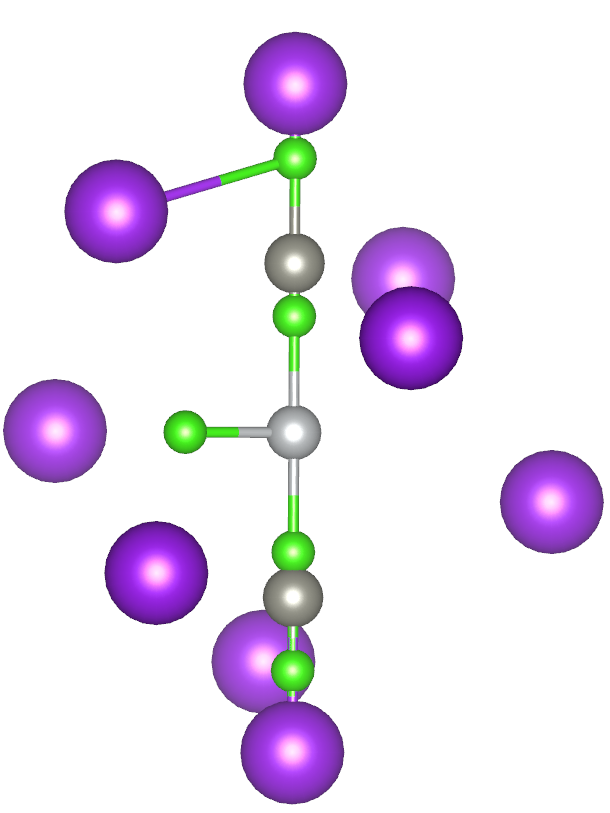

In [9]:
from IPython.display import Image
Image(filename='/content/Xron/Objective_training/Data_NiClZnK/GA/NiClZnK_initial.png', width=200)

In [ ]:
# write optimized structure to a file
# convert to xyz
# add the absorber at 0,0,0
#write_xyz_file_multiatom('/content/Xron/Objective_training/Data_NiClZnK/GA/NiClZnK_1.xyz',  np.concatenate((np.array([[0,0,0]]),to_xyz(optimized_structure))), atom_ids)

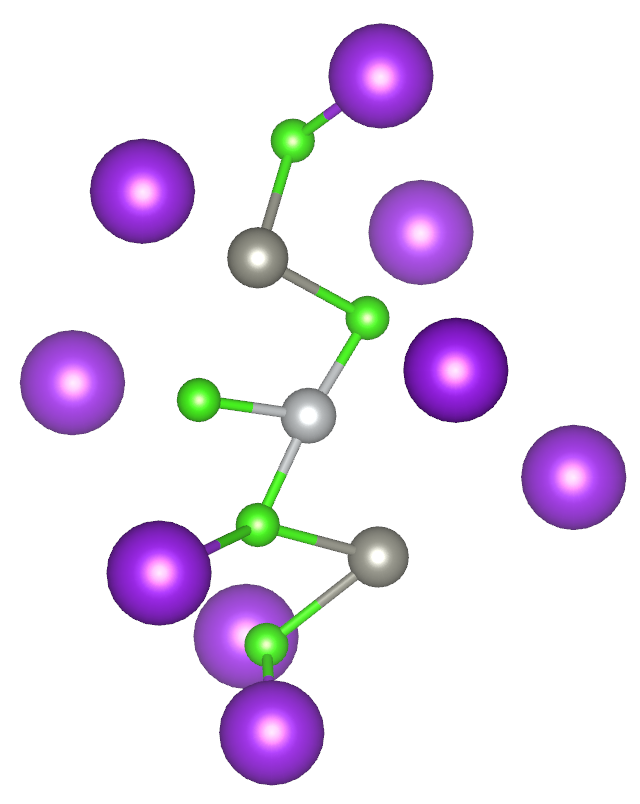

In [10]:
from IPython.display import Image
Image(filename='/content/Xron/Objective_training/Data_NiClZnK/GA/optimized_NiClZnK.png', width=200)

# Make Training and Testing data (do not run)

In [ ]:
rmesh = np.arange(0,6,.05)

def specific_data(path):

    xmu_files=glob.glob(path+"/*/*xmu.dat")
    feff_files= [l.replace("xmu.dat", "feff.inp") for l in xmu_files]

    all_exafs_0_s=[]
    all_rdf_0_s=[]
    for i,spectra in enumerate(xmu_files):
        all_exafs_0_s.append(read_exafs_dat(spectra))
        all_coords=np.asarray([l.split() for l in read_lines(feff_files[i])[13:-1]])[:,0:3].astype(float)[1:]
        all_coords_index=np.asarray([l.split() for l in read_lines(feff_files[i])[13:-1]])[:,3].astype(float)[1:]
        all_coords_index_cl=all_coords[np.where(all_coords_index==1)]
        all_coords_index_zn=all_coords[np.where(all_coords_index==2)]
        all_coords_index_k=all_coords[np.where(all_coords_index==3)]
        distances_cl=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_cl, fastdist.euclidean, "euclidean") if 0<l<6]
        distances_zn=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_zn, fastdist.euclidean, "euclidean") if 0<l<6]
        distances_k=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_k, fastdist.euclidean, "euclidean") if 0<l<6]
        all_rdf_0_s.append(np.array([make_rdf_feff(distances_cl, rmesh), make_rdf_feff(distances_zn, rmesh), make_rdf_feff(distances_k, rmesh)]))


    all_exafs_0_s = np.asarray(all_exafs_0_s)
    all_exafs_0_s = [[l for l in s if 2<=l[0]<=12 ] for s in all_exafs_0_s]
    all_exafs_0_s = np.asarray(all_exafs_0_s)
    all_exafs_0_k2_s = []
    for spectrum in all_exafs_0_s:
        x, y = spectrum.transpose()
        all_exafs_0_k2_s.append(np.array([x,y*x**2]).transpose())
    all_exafs_0_k2_s = np.asarray(all_exafs_0_k2_s)

    bad_exafs_s=[i for i,l in enumerate(all_exafs_0_k2_s) if max(l.transpose()[1])>5]
    all_exafs_0_k2_s = np.delete(all_exafs_0_k2_s, bad_exafs_s, axis=0)
    all_rdf_0_s = np.delete(all_rdf_0_s, bad_exafs_s, axis=0)


    all_exafs_s=np.mean(np.asarray(all_exafs_0_k2_s),axis=0)

    all_rdf_s=np.mean(np.asarray(all_rdf_0_s),axis=0)

    rdf_cl, rdf_zn, rdf_k = all_rdf_s

    return interpol(all_exafs_s), rdf_cl, rdf_zn, rdf_k

In [ ]:
paths = glob.glob("C:/FEFF10_local/batch_test_3/archive/*") + glob.glob("A:/Objective_training\Output\All_together/*/*/*")

special_bois = []
for path in paths:
    if len(glob.glob(path+"/*/*xmu.dat"))>=80:
        exafs, rdf_cl, rdf_zn, rdf_k = specific_data(path)
        special_bois.append([exafs, rdf_cl, rdf_zn, rdf_k])
    else:
        pass

In [ ]:
special_bois = np.array([example for example in special_bois if np.max(example[0])<2])

C:\Users\nickj\AppData\Local\Temp\ipykernel_34668\3336404876.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  special_bois = np.array([example for example in special_bois if np.max(example[0])<2])


In [ ]:
#pickle.dump(special_bois, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/special_bois.pkl", "wb"))

## (4) Load base data (configuration averages) for training NN.

In [14]:
special_bois = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/special_bois.pkl", "rb"))
rmesh = np.arange(0,6,.05)

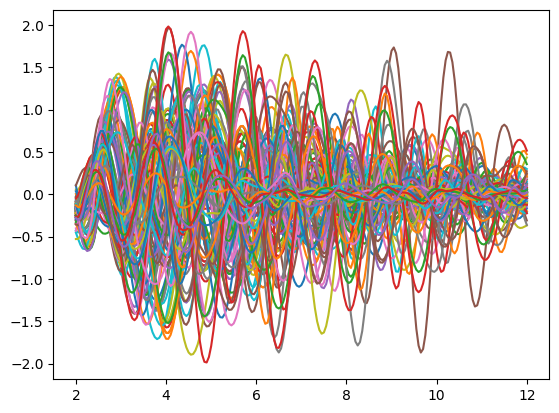

In [12]:
for i,boi in enumerate(special_bois):
    plt.plot(kspace, boi[0])

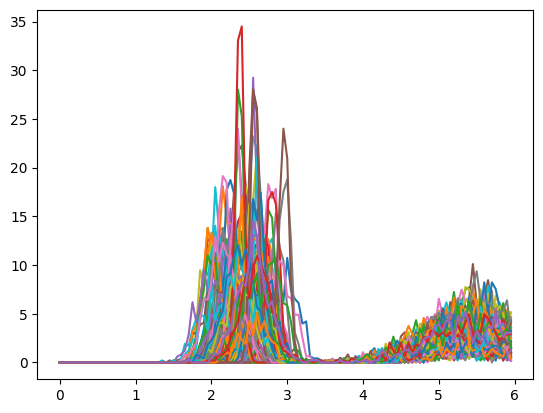

In [15]:
for i,boi in enumerate(special_bois):
    plt.plot(rmesh, boi[1])

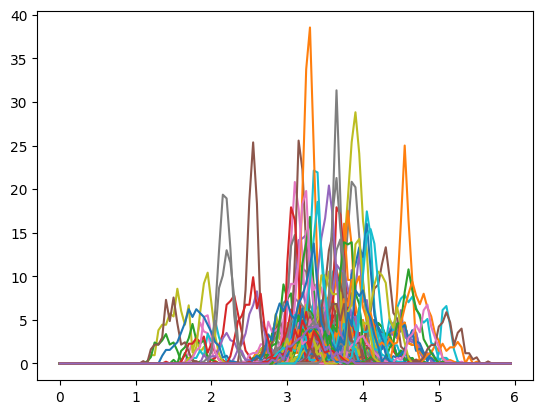

In [16]:
for i,boi in enumerate(special_bois):
    plt.plot(rmesh, boi[2])

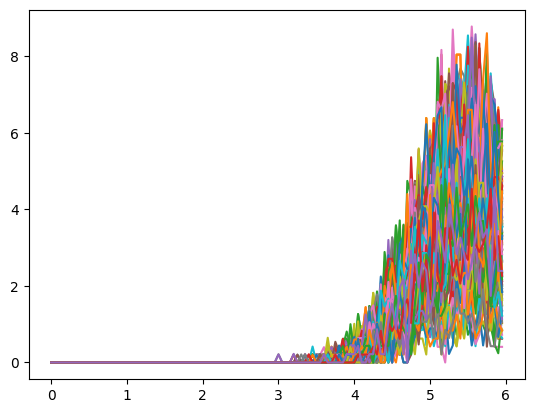

In [17]:
for i,boi in enumerate(special_bois):
    plt.plot(rmesh, boi[3])

(0.0, 40.0)

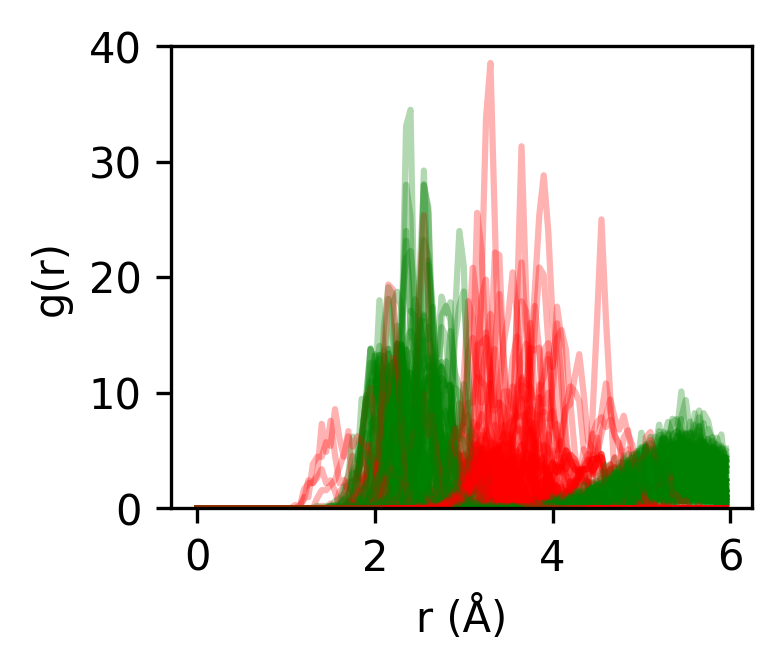

In [18]:
fig, axs = plt.subplots(1,1, figsize=(2.5,2), dpi=300)
for i in special_bois:
    axs.plot(rmesh, i[1], c="green", alpha=0.3)
    axs.plot(rmesh, i[2], c="red", alpha=0.3)
axs.set_xlabel("r (Å)")
axs.set_ylabel("g(r)")
axs.set_ylim(0,40)


These functions are used to create the training and validation data

In [ ]:
def combinator_s(num_special_bois, special_bois):
    ran_i = np.random.randint(1, 5, 1)
    ran_bois = np.random.choice(num_special_bois, ran_i, replace=False)

    weights = np.random.dirichlet(np.ones(ran_i),size=1)[0]

    bois = special_bois[ran_bois]
    exafs_weighted = np.average([boi[0] for boi in bois], axis=0, weights=weights)
    rdf_zn_weighted = np.average([boi[2] for boi in bois], axis=0, weights=weights)
    rdf_cl_weighted = np.average([boi[1] for boi in bois], axis=0, weights=weights)

    return exafs_weighted, rdf_cl_weighted[20:60], rdf_zn_weighted[40:100]

def generate_examples(num_examples, num_special_bois, special_bois):
    examples = np.zeros((num_examples, 3), dtype=object) # change to 2 if only using 1 rdf
    for i in range(num_examples):
        examples[i] = combinator_s(num_special_bois, special_bois)
    exafs_examples, rdf_examples_cl, rdf_examples_zn = zip(*examples)
    exafs_examples = np.asarray(exafs_examples)
    rdf_examples_zn = np.asarray(rdf_examples_zn)
    rdf_examples_cl = np.asarray(rdf_examples_cl)
    rdf_examples_zip = np.array([np.concatenate((rdf_examples_cl[i], rdf_examples_zn[i])) for i in range(len(exafs_examples))])
    return exafs_examples, rdf_examples_zip

def data_generator(batch_size, num_special_bois, special_bois):
    while True:
        x_batch_0, y_batch = generate_examples(batch_size, num_special_bois, special_bois)
        x_batch = x_batch_0.reshape(x_batch_0.shape[0], x_batch_0.shape[1], 1)
        n_level = np.random.uniform(low=0.0, high=0.6)
        noise = np.random.normal(loc=0, scale=n_level, size=x_batch.shape)
        yield x_batch + noise, y_batch

num_special_bois = len(special_bois)
#exafs_examples, rdf_examples_zip = generate_examples(200000, num_special_bois, special_bois)
#x_train, x_test, y_train, y_test = train_test_split(exafs_examples, rdf_examples_zip, test_size=0.33)

In [ ]:
#x_train_rs = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
#x_test_rs = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


## (5) Load NN training and validation data

In [19]:
# pickle.dump(x_train_rs, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_train_rs.pkl", "wb"))
# pickle.dump(x_test_rs, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_test_rs.pkl", "wb"))
# pickle.dump(y_train, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_train.pkl", "wb"))
# pickle.dump(y_test, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_test.pkl", "wb"))

x_train_rs = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_train_rs.pkl", "rb"))
x_test_rs = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_test_rs.pkl", "rb"))
y_train = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_train.pkl", "rb"))
y_test = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_test.pkl", "rb"))

(0.0, 40.0)

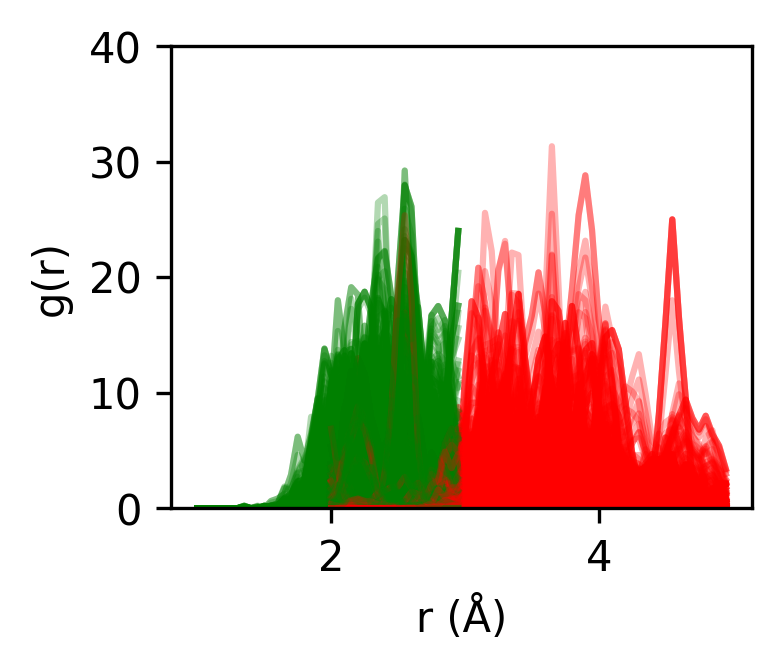

In [20]:
fig, axs = plt.subplots(1,1, figsize=(2.5,2), dpi=300)
for i in y_train[:1000]:
    axs.plot(rmesh[20:60], i[:40], c="green", alpha=0.3)
    axs.plot(rmesh[40:100], i[40:], c="red", alpha=0.3)
axs.set_xlabel("r (Å)")
axs.set_ylabel("g(r)")
axs.set_ylim(0,40)

# Test data (AIMD) dont run

## Comp 1

In [ ]:
ai_md_path = "A:/NiCl_AI_MD_recalculate/out/ai_md_recal_ni_1_fix/"
xmu_files_ai=glob.glob(ai_md_path+"/*/*/*xmu.dat")
feff_files_ai= [l.replace("xmu.dat", "feff.inp") for l in xmu_files_ai]

all_exafs_ai_0=[]
all_rdf_ai_0=[]
for i,spectra in enumerate(xmu_files_ai):
    all_exafs_ai_0.append(read_exafs_dat(spectra))
    all_coords=np.asarray([l.split() for l in read_lines(feff_files_ai[i])[13:-1]])[:,0:3].astype(float)[1:]
    all_coords_index=np.asarray([l.split() for l in read_lines(feff_files_ai[i])[13:-1]])[:,3].astype(float)[1:]
    all_coords_index_cl=all_coords[np.where(all_coords_index==1)]
    all_coords_index_zn=all_coords[np.where(all_coords_index==2)]
    all_coords_index_k=all_coords[np.where(all_coords_index==3)]
    distances_cl=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_cl, fastdist.euclidean, "euclidean") if 0<l<6]
    distances_zn=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_zn, fastdist.euclidean, "euclidean") if 0<l<6]
    distances_k=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_k, fastdist.euclidean, "euclidean") if 0<l<6]
    all_rdf_ai_0.append(np.array([make_rdf_feff(distances_cl, rmesh), make_rdf_feff(distances_zn, rmesh), make_rdf_feff(distances_k, rmesh)]))
all_exafs_ai=np.mean(np.asarray(all_exafs_ai_0),axis=0)

all_rdf_ai=np.mean(np.asarray(all_rdf_ai_0),axis=0)

## (6) Load AIMD test data from Comp 1

In [21]:
# pickle.dump(all_rdf_ai, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai.pkl", "wb"))
# pickle.dump(all_exafs_ai, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai.pkl", "wb"))
# pickle.dump(all_exafs_ai_0, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_0.pkl", "wb"))
# pickle.dump(all_rdf_ai_0, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_0.pkl", "wb"))

all_rdf_ai = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai.pkl", "rb"))
all_exafs_ai = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai.pkl", "rb"))
#all_exafs_ai_0 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_0.pkl", "rb"))
#all_rdf_ai_0 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_0.pkl", "rb"))


## Comp 2

In [ ]:
ai_md_path = "D:/Machine Learning Data/NiCl_MD/for-Yang/Ni-2/spectra"
xmu_files_ai=glob.glob(ai_md_path+"/*.dat")
feff_files_ai= glob.glob("A:/NiCl_AI_MD_recalculate/Ni-2/frame_0/*/*feff.inp")
all_exafs_ai_0_2=[]
all_rdf_ai_0_2=[]
for i,spectra in enumerate(xmu_files_ai[:-3]):
    all_exafs_ai_0_2.append(np.array([l.split() for l in read_lines(spectra)]).astype(float))
    all_coords=np.asarray([l.split() for l in read_lines(feff_files_ai[i])[13:-1]])[:,0:3].astype(float)[1:]
    all_coords_index=np.asarray([l.split() for l in read_lines(feff_files_ai[i])[13:-1]])[:,3].astype(float)[1:]
    all_coords_index_cl=all_coords[np.where(all_coords_index==1)]
    all_coords_index_zn=all_coords[np.where(all_coords_index==2)]
    all_coords_index_k=all_coords[np.where(all_coords_index==3)]
    distances_cl=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_cl, fastdist.euclidean, "euclidean") if 0<l<6]
    distances_zn=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_zn, fastdist.euclidean, "euclidean") if 0<l<6]
    distances_k=[l for l in fastdist.vector_to_matrix_distance(np.asarray([0,0,0]), all_coords_index_k, fastdist.euclidean, "euclidean") if 0<l<6]
    all_rdf_ai_0_2.append(np.array([make_rdf_feff(distances_cl,rmesh), make_rdf_feff(distances_zn,rmesh), make_rdf_feff(distances_k,rmesh)]))

all_exafs_ai_2=np.mean(np.asarray(all_exafs_ai_0_2),axis=0)
all_rdf_ai_2=np.mean(np.asarray(all_rdf_ai_0_2),axis=0)


## (7) Load AIMD test data from Comp 2

In [22]:
# pickle.dump(all_rdf_ai_2, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_2.pkl", "wb"))
# pickle.dump(all_exafs_ai_2, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_2.pkl", "wb"))
# pickle.dump(all_exafs_ai_0_2, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_0_2.pkl", "wb"))
# pickle.dump(all_rdf_ai_0_2, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_0_2.pkl", "wb"))

all_rdf_ai_2 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_2.pkl", "rb"))
all_exafs_ai_2 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_2.pkl", "rb"))
#all_exafs_ai_0_2 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_exafs_ai_0_2.pkl", "rb"))
#all_rdf_ai_0_2 = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/all_rdf_ai_0_2.pkl", "rb"))

# NN Training (Dont run)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Activation
from keras.models import Sequential
from tensorflow.keras.models import Model

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)


for experiment in [1,2,3,4,5,6,7,8,9,10]:

    model = Sequential()

    model.add(Conv1D(64, kernel_size=3, input_shape=(201, 1)))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(3*256))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.2))

    model.add(Dense(100))


    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    #model.compile(loss=weighted_mse, optimizer=optimizer)

    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4, min_delta=0.0001, restore_best_weights=True)

    batch_size = 128
    steps_per_epoch = int(40000 / batch_size)  # or some other value that fits your dataset size

    # Train the model
    model.fit(data_generator(batch_size, num_special_bois, special_bois), batch_size=batch_size, epochs=100, steps_per_epoch=steps_per_epoch, validation_data= (x_train_rs, y_train), callbacks=[callback])

    keras.models.save_model(model, f'C:/PyRepo/Package/Xron/Objective_training/Data_NiClZnK/NN/Model/Model_6/Objective_40_{experiment}')

## (8) load trained NNs

In [25]:
from tensorflow import keras
exp_names = glob.glob("/content/Xron/Objective_training/Data_NiClZnK/NN/Model/Model_6/*")
model_dict_40k_af = {}
for e_n in exp_names:
    model = keras.models.load_model(e_n)
    model_dict_40k_af[int(e_n.split("/")[-1].split("_")[-1])] = model

In [26]:
runner2 = ModelRunner2(model_dict_40k_af, x_test_rs, y_test, rmesh)

1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 111ms/step


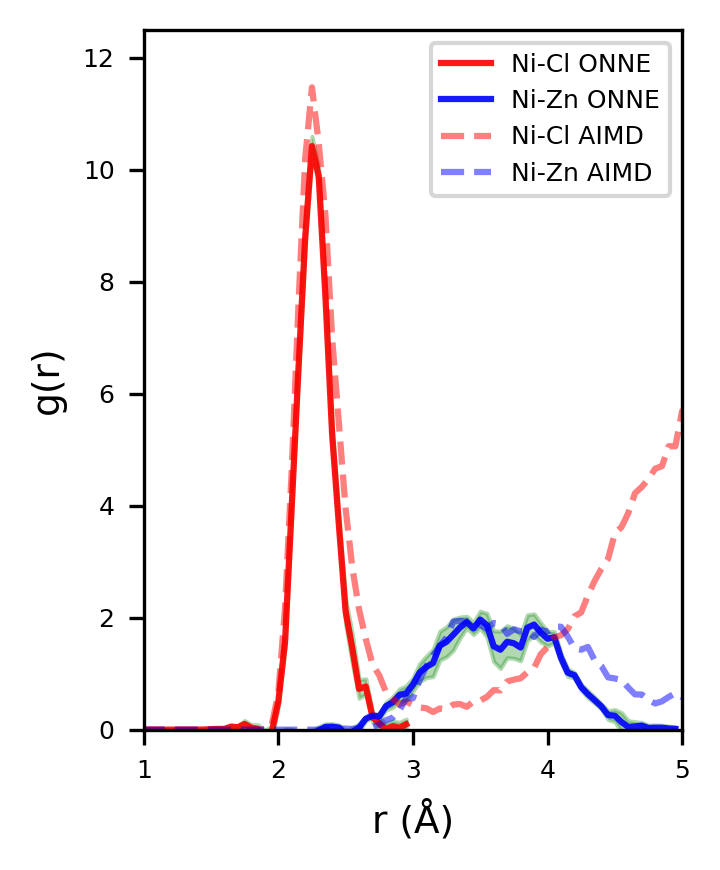

In [27]:
ai_cl, ai_zn, ai_k = all_rdf_ai
runner2.plot_mean_std_predictions(intpol(k2(all_exafs_ai), kspace), ai_cl, ai_zn)

1/1 [==============================] - 0s 26ms/step


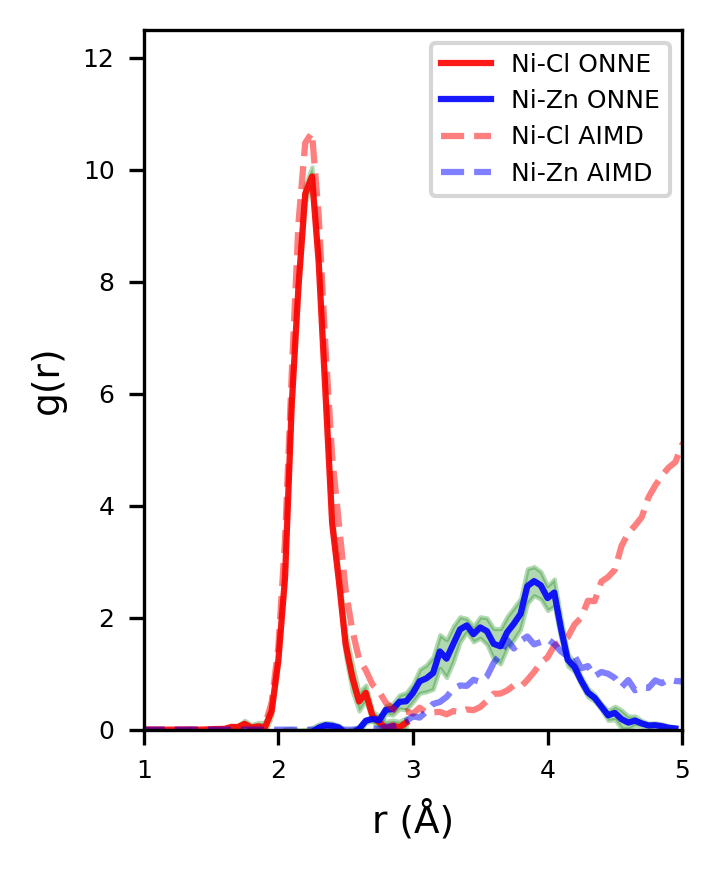

In [28]:
ai_cl, ai_zn, ai_k = all_rdf_ai_2
runner2.plot_mean_std_predictions(intpol(k2(all_exafs_ai_2), kspace), ai_cl, ai_zn)

# Fine Tune

## Fine Tune Data (dont run)

In [ ]:
# This code groups the data by the center of mass of the first shell (com_cl) and the second shell (com_zn) for comp 1 and then comp 2.
# The data is added to two lists, x_test2_ai and y_test2_ai.

# comp 1

com_zn = [np.average(rmesh,weights=rdfs[1]) for rdfs in all_rdf_ai_0]
com_cl = [np.average(rmesh[20:60],weights=rdfs[0][20:60]) for rdfs in all_rdf_ai_0]


com_n = com_cl
counts, bin_edges = np.histogram(com_n, bins=20)
ranges = np.array([bin_edges[:-1], bin_edges[1:]]).T
groups = []
groups_x = []
for range_ in ranges:
    r_group = []
    x_group = []
    for i,com in enumerate(com_n):
        if range_[0]<=com<=range_[1]:
            r_group.append(all_rdf_ai_0[i])
            x_group.append(all_exafs_ai_0[i])
    groups.append(r_group)
    groups_x.append(x_group)

x_test2_ai = []
y_test2_ai = []

for i,group in enumerate(groups_x):
    plot_me = np.mean(np.array([interpol(k2(l)) for l in group]),axis=0)
    x_test2_ai.append(plot_me)

for i,group in enumerate(groups):
    rdf_cl = np.mean(np.array([l[0] for l in group]),axis=0)[20:60]
    rdf_zn = np.mean(np.array([l[1] for l in group]),axis=0)[40:100]
    ziped = np.concatenate((rdf_cl, rdf_zn))
    y_test2_ai.append(ziped)


com_n = com_zn
counts, bin_edges = np.histogram(com_n, bins=30)
ranges = np.array([bin_edges[:-1], bin_edges[1:]]).T
groups = []
groups_x = []
for range_ in ranges:
    r_group = []
    x_group = []
    for i,com in enumerate(com_n):
        if range_[0]<=com<=range_[1]:
            r_group.append(all_rdf_ai_0[i])
            x_group.append(all_exafs_ai_0[i])
    groups.append(r_group)
    groups_x.append(x_group)

for i,group in enumerate(groups_x):
    plot_me = np.mean(np.array([interpol(k2(l)) for l in group]),axis=0)
    x_test2_ai.append(plot_me)

for i,group in enumerate(groups):
    rdf_cl = np.mean(np.array([l[0] for l in group]),axis=0)[20:60]
    rdf_zn = np.mean(np.array([l[1] for l in group]),axis=0)[40:100]
    ziped = np.concatenate((rdf_cl, rdf_zn))
    y_test2_ai.append(ziped)


com_zn = [np.average(rmesh,weights=rdfs[1]) for rdfs in all_rdf_ai_0]
com_cl = [np.average(rmesh[20:60],weights=rdfs[0][20:60]) for rdfs in all_rdf_ai_0]


com_n = com_cl
counts, bin_edges = np.histogram(com_n, bins=20)
ranges = np.array([bin_edges[:-1], bin_edges[1:]]).T
groups = []
groups_x = []
for range_ in ranges:
    r_group = []
    x_group = []
    for i,com in enumerate(com_n):
        if range_[0]<=com<=range_[1]:
            r_group.append(all_rdf_ai_0[i])
            x_group.append(all_exafs_ai_0[i])
    groups.append(r_group)
    groups_x.append(x_group)

# comp 2

# In comp 2, some of the examples contain 0 Zn atoms. This causes an error when trying to compute the center of mass using the previous method.
# The following code is a workaround for this problem.

# Extract the weights from all_rdf_ai_0_2
all_weights = np.array([rdfs[1] for rdfs in all_rdf_ai_0_2])
# Sum the weights along the desired axis
sum_weights = np.sum(all_weights, axis=1)
# Pre-allocate the array for the center of mass
com_zn_2 = np.empty_like(sum_weights)
# Loop through and compute the average for each set of weights
for i, weights in enumerate(all_weights):
    com_zn_2[i] = 0.0 if sum_weights[i] == 0 else np.average(rmesh, weights=weights)


com_cl = [np.average(rmesh[20:60],weights=rdfs[0][20:60]) for rdfs in all_rdf_ai_0_2]


com_n = com_cl
counts, bin_edges = np.histogram(com_n, bins=20)
ranges = np.array([bin_edges[:-1], bin_edges[1:]]).T
groups = []
groups_x = []
for range_ in ranges:
    r_group = []
    x_group = []
    for i,com in enumerate(com_n):
        if range_[0]<=com<=range_[1]:
            r_group.append(all_rdf_ai_0_2[i])
            x_group.append(all_exafs_ai_0_2[i])
    groups.append(r_group)
    groups_x.append(x_group)


for i,group in enumerate(groups_x):
    plot_me = np.mean(np.array([interpol(k2(l)) for l in group]),axis=0)
    x_test2_ai.append(plot_me)

for i,group in enumerate(groups):
    rdf_cl = np.mean(np.array([l[0] for l in group]),axis=0)[20:60]
    rdf_zn = np.mean(np.array([l[1] for l in group]),axis=0)[40:100]
    ziped = np.concatenate((rdf_cl, rdf_zn))
    y_test2_ai.append(ziped)


com_n = com_zn_2
counts, bin_edges = np.histogram(com_n, bins=30)
ranges = np.array([bin_edges[:-1], bin_edges[1:]]).T
groups = []
groups_x = []
for range_ in ranges:
    r_group = []
    x_group = []
    for i,com in enumerate(com_n):
        if range_[0]<=com<=range_[1]:
            r_group.append(all_rdf_ai_0_2[i])
            x_group.append(all_exafs_ai_0_2[i])
    groups.append(r_group)
    groups_x.append(x_group)

# we check if the group is empty, if it is we skip it
# if it is not we compute the mean of the exafs and the rdf and append it to the list

for i,group in enumerate(groups):
    if len(group)==0:
        continue
    else:
        plot_me = np.mean(np.array([interpol(k2(l)) for l in groups_x[i]]),axis=0)
        x_test2_ai.append(plot_me)
        rdf_cl = np.mean(np.array([l[0] for l in group]),axis=0)[20:60]
        rdf_zn = np.mean(np.array([l[1] for l in group]),axis=0)[40:100]
        ziped = np.concatenate((rdf_cl, rdf_zn))
        y_test2_ai.append(ziped)

# convert the lists to arrays
x_test2_ai = np.array(x_test2_ai)
y_test2_ai = np.array(y_test2_ai)


In [ ]:
len(x_test2_ai)

86

In [ ]:
# We separate the data into training and test sets
use_in_training = np.random.choice(len(x_test2_ai), 60, replace=False)
remove_from_test = np.delete(np.arange(len(x_test2_ai)), use_in_training)

In [ ]:
len(use_in_training), len(remove_from_test)

(60, 26)

In [ ]:
# separate the data into training and test sets
x_ft_train = x_test2_ai[use_in_training]
y_ft_train = y_test2_ai[use_in_training]

x_ft_test = x_test2_ai[remove_from_test]
y_ft_test = y_test2_ai[remove_from_test]


## (9) Load fine tune training data

In [29]:
# pickle.dump(x_ft_train, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_ft_train.pkl", "wb"))
# pickle.dump(y_ft_train, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_ft_train.pkl", "wb"))
# pickle.dump(x_ft_test, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_ft_test.pkl", "wb"))
# pickle.dump(y_ft_test, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_ft_test.pkl", "wb"))

x_ft_train = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_ft_train.pkl", "rb"))
y_ft_train = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_ft_train.pkl", "rb"))
x_ft_test = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_ft_test.pkl", "rb"))
y_ft_test = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_ft_test.pkl", "rb"))

(0.0, 40.0)

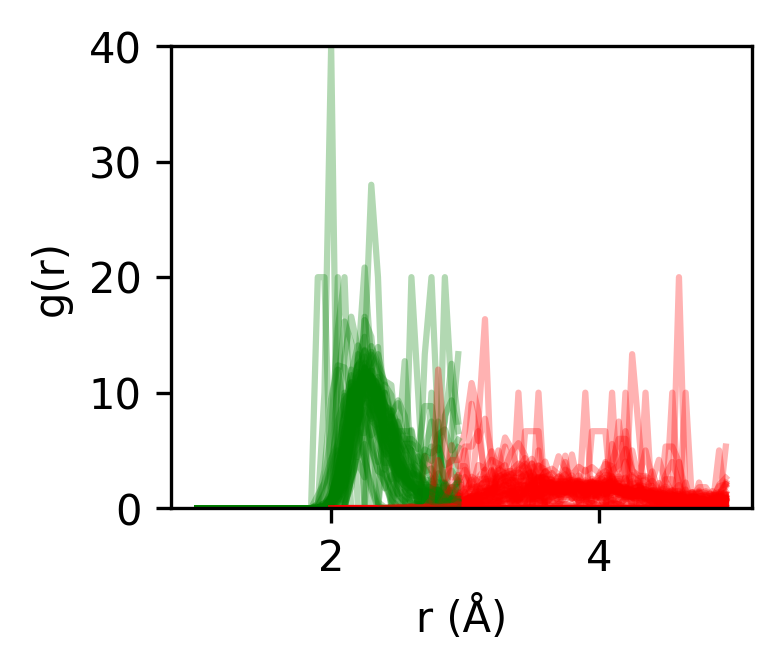

In [30]:
# this is what the training data looks like
fig, axs = plt.subplots(1,1, figsize=(2.5,2), dpi=300)
for i in y_ft_train:
    axs.plot(rmesh[20:60], i[:40], c="green", alpha=0.3)
    axs.plot(rmesh[40:100], i[40:], c="red", alpha=0.3)
axs.set_xlabel("r (Å)")
axs.set_ylabel("g(r)")
axs.set_ylim(0,40)


(0.0, 40.0)

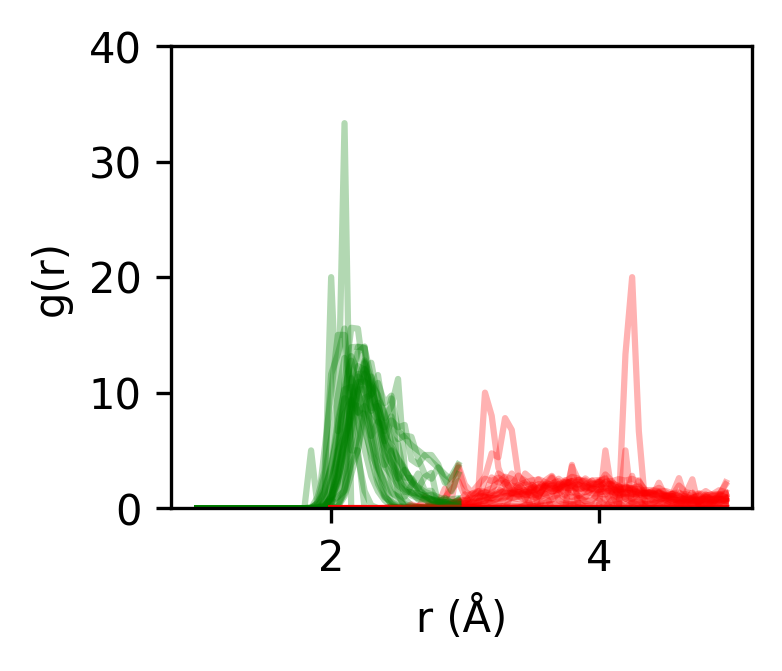

In [31]:
# this is what the test data looks like
fig, axs = plt.subplots(1,1, figsize=(2.5,2), dpi=300)
for i in y_ft_test:
    axs.plot(rmesh[20:60], i[:40], c="green", alpha=0.3)
    axs.plot(rmesh[40:100], i[40:], c="red", alpha=0.3)
axs.set_xlabel("r (Å)")
axs.set_ylabel("g(r)")
axs.set_ylim(0,40)

In [ ]:
# the functions are modified to work with the new data

def combinator_s_ft(num):
    num_special_bois = len(x_ft_train)
    #ran_i = np.random.randint(1, num_special_bois+1, 1)
    ran_i = np.random.randint(1, 5, 1)
    ran_bois = np.random.randint(0, num_special_bois, ran_i)

    weights = np.random.dirichlet(np.ones(ran_i),size=1)
    weights = weights[0]

    exafs = x_ft_train[ran_bois]
    exafs = np.array(exafs)

    rdf_zn = y_ft_train[ran_bois][:,40:]
    rdf_zn = np.array(rdf_zn)

    rdf_cl = y_ft_train[ran_bois][:,:40]
    rdf_cl = np.array(rdf_cl)

    exafs_weighted = np.average(exafs, axis=0, weights=weights)
    rdf_zn_weighted = np.average(rdf_zn, axis=0, weights=weights)
    rdf_cl_weighted = np.average(rdf_cl, axis=0, weights=weights)

    return exafs_weighted, rdf_cl_weighted, rdf_zn_weighted

def combinator_s_ft_test(num):
    num_special_bois = len(x_ft_test)
    #ran_i = np.random.randint(1, num_special_bois+1, 1)
    ran_i = np.random.randint(1, 5, 1)
    ran_bois = np.random.randint(0, num_special_bois, ran_i)

    weights = np.random.dirichlet(np.ones(ran_i),size=1)
    weights = weights[0]

    exafs = x_ft_test[ran_bois]
    exafs = np.array(exafs)

    rdf_zn = y_ft_test[ran_bois][:,40:]
    rdf_zn = np.array(rdf_zn)

    rdf_cl = y_ft_test[ran_bois][:,:40]
    rdf_cl = np.array(rdf_cl)

    exafs_weighted = np.average(exafs, axis=0, weights=weights)
    rdf_zn_weighted = np.average(rdf_zn, axis=0, weights=weights)
    rdf_cl_weighted = np.average(rdf_cl, axis=0, weights=weights)

    return exafs_weighted, rdf_cl_weighted, rdf_zn_weighted

def generate_examples_ft(num_examples):
    exafs_examples = []
    rdf_examples_zn = []
    rdf_examples_cl = []
    for i in range(num_examples):
        exafs_example, rdf_example_cl,  rdf_example_zn = combinator_s_ft(3)
        exafs_examples.append(exafs_example)
        rdf_examples_zn.append(rdf_example_zn)
        rdf_examples_cl.append(rdf_example_cl)
    exafs_examples = np.asarray(exafs_examples)
    rdf_examples_zn = np.asarray(rdf_examples_zn)
    rdf_examples_cl = np.asarray(rdf_examples_cl)
    rdf_examples_zip = []
    for i in range(len(exafs_examples)):
        rdf_examples_zip.append(np.concatenate((rdf_examples_cl[i], rdf_examples_zn[i])))
    rdf_examples_zip = np.asarray(rdf_examples_zip)
    return exafs_examples, rdf_examples_zip

def data_generator_ft(batch_size):
    while True:
        x_batch_0, y_batch = generate_examples_ft(batch_size)
        x_batch = x_batch_0.reshape(x_batch_0.shape[0], x_batch_0.shape[1], 1)
        noise = np.random.normal(loc=0, scale=0.5, size=x_batch.shape)
        n_samples, n_features = x_batch.shape[:2]
        yield x_batch+noise, y_batch

In [ ]:
# validation data is generated (data from the test set and no noise)
exafs_examples = []
rdf_examples_zn = []
rdf_examples_cl = []

for i in range(20000):
    exafs_example, rdf_example_cl,  rdf_example_zn = combinator_s_ft_test(3)
    exafs_examples.append(exafs_example)
    rdf_examples_zn.append(rdf_example_zn)
    rdf_examples_cl.append(rdf_example_cl)

exafs_examples = np.asarray(exafs_examples)
rdf_examples_zn = np.asarray(rdf_examples_zn)
rdf_examples_cl = np.asarray(rdf_examples_cl)


rdf_examples_zip = []
for i in range(len(exafs_examples)):
    rdf_examples_zip.append(np.concatenate((rdf_examples_cl[i], rdf_examples_zn[i])))

rdf_examples_zip = np.asarray(rdf_examples_zip)

x_val_ft, x_val_ft_2, y_val_ft, y_val_ft_2 = train_test_split(exafs_examples, rdf_examples_zip, test_size=0.50)
# the validation data is reshaped to fit the model
x_val_ft_rs = x_val_ft.reshape(x_val_ft.shape[0], x_val_ft.shape[1], 1)

## (10) Load fine tune validation data

In [32]:
# pickle.dump(x_val_ft_rs, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_val_ft_rs.pkl", "wb"))
# pickle.dump(y_val_ft, open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_val_ft.pkl", "wb"))

x_val_ft_rs = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/x_val_ft_rs.pkl", "rb"))
y_val_ft = pickle.load(open("/content/Xron/Objective_training/Data_NiClZnK/NN/Training_Data/y_val_ft.pkl", "rb"))

In [ ]:
# the model is trained for 10 experiments
for experiment in [1,2,3,4,5,6,7,8,9,10]:

    base_model = model_dict_40k_af[experiment]

    num_classes = 100
    x = base_model.output
    x = Dense(256, activation='selu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='selu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='linear')(x)


    for layer in base_model.layers:
        layer.trainable = False


    model2 = Model(inputs=base_model.input, outputs=predictions)
    model2.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=[tf.keras.metrics.MeanSquaredError()])


    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, min_delta=0.001, restore_best_weights=True)

    batch_size = 128
    steps_per_epoch = int(30000 / batch_size)  # or some other value that fits your dataset size

    # Train the model
    model2.fit(data_generator_ft(batch_size), batch_size=batch_size, epochs=100, steps_per_epoch=steps_per_epoch, verbose=1,validation_data=(x_val_ft_rs, y_val_ft), callbacks=[callback])

    keras.models.save_model(model2, f'C:/PyRepo/Package/Xron/Objective_training/Data_NiClZnK/NN/Model/Model_6_FT/Objective_40_{experiment}')

## (11) Load Fine Tuned Models

In [33]:
from tensorflow import keras

exp_names = glob.glob("/content/Xron/Objective_training/Data_NiClZnK/NN/Model/Model_6_FT/*")
model_dict_fine = {}
for e_n in exp_names:
    model = keras.models.load_model(e_n)
    model_dict_fine[int(e_n.split("/")[-1].split("_")[-1])] = model

## Fine tune predictions

In [34]:
# the 10 models are plotted with this function. the 3rd and 4th arguments dont matter.
runner2 = ModelRunner2(model_dict_fine, x_test_rs, y_test, rmesh)

1/1 [==============================] - 0s 137ms/step


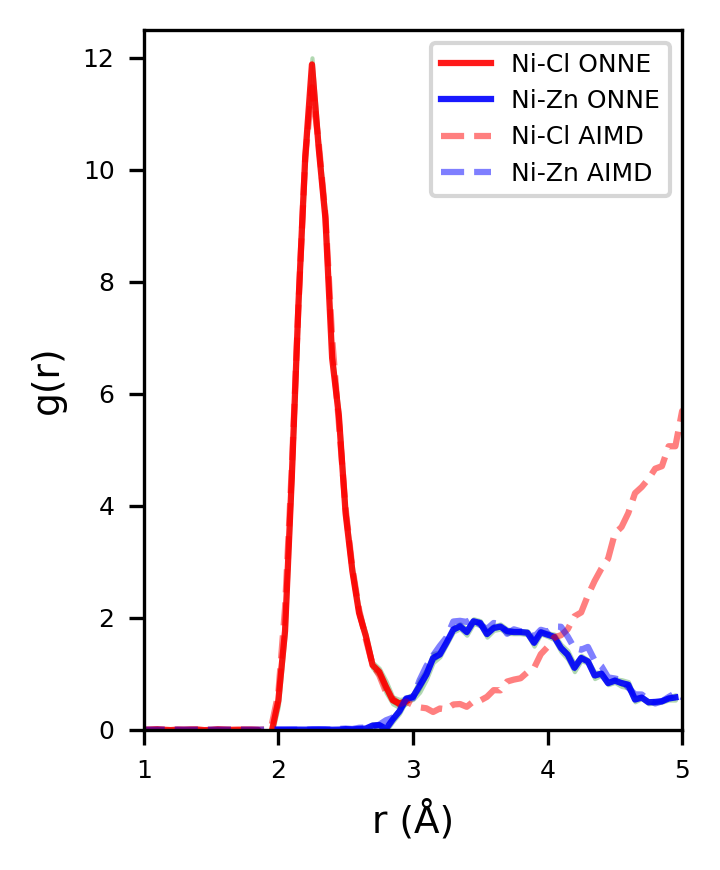

In [35]:
ai_cl, ai_zn, ai_k = all_rdf_ai
runner2.plot_mean_std_predictions(intpol(k2(all_exafs_ai), kspace), ai_cl, ai_zn)

1/1 [==============================] - 0s 19ms/step


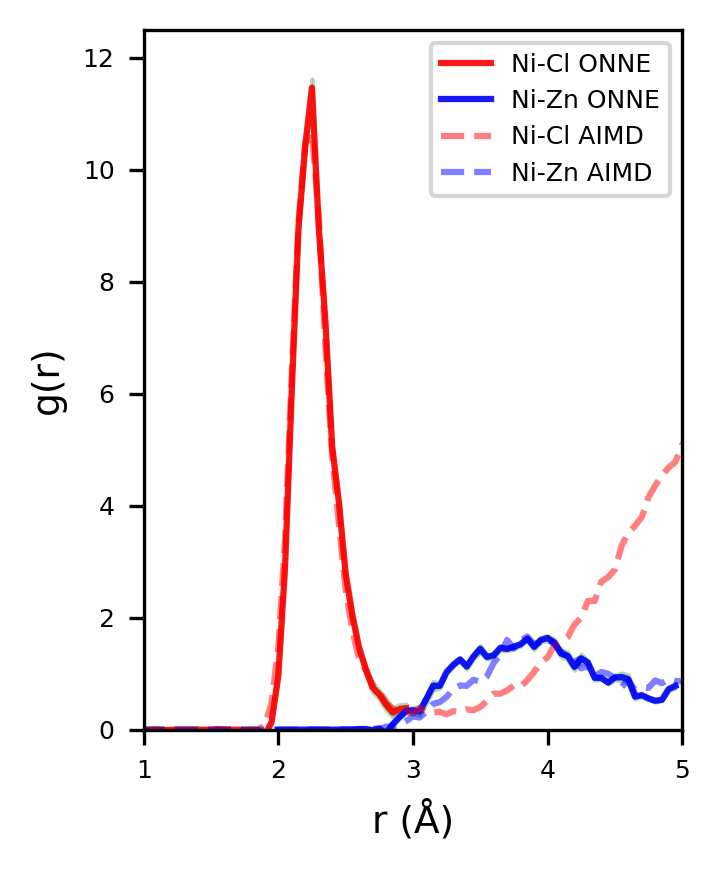

In [36]:
ai_cl, ai_zn, ai_k = all_rdf_ai_2
runner2.plot_mean_std_predictions(intpol(k2(all_exafs_ai_2), kspace), ai_cl, ai_zn)